In [112]:
import requests
import pandas as pd

# Function to get instrument data (as you already have)
def fetch_deribit_options_data(symbol='BTC', kind='option', expiration=None):
    url = f'https://www.deribit.com/api/v2/public/get_instruments?currency={symbol}&kind={kind}&expired=false'
    response = requests.get(url)
    data = response.json()['result']
    
    # Filter by expiration date if provided
    if expiration:
        data = [option for option in data if option['expiration_timestamp'] == expiration]
    
    return data

# Function to get market data for a specific option (to fetch premiums)
def fetch_deribit_option_price(instrument_name):
    url = f"https://www.deribit.com/api/v2/public/get_order_book?instrument_name={instrument_name}"
    response = requests.get(url)
    mark_price = response.json().get("result", {}).get("mark_price")
    underlying_btc_price = response.json().get("result", {}).get("underlying_price")
    if mark_price is not None and underlying_btc_price is not None:
        return mark_price * underlying_btc_price
    return None

# Fetch BTC options data
btc_options_data = fetch_deribit_options_data(symbol='BTC')

# Create separate DataFrames for calls and puts
calls_data = []
puts_data = []

expiry_dates = {}

for option in btc_options_data:
    option_type = option['option_type']
    strike = option['strike']
    instrument_name = option['instrument_name']  # Unique name of the instrument

    expiry_dates[instrument_name] = expiry_dates.setdefault(instrument_name, 0) + 1

    if "29NOV24" in instrument_name:

        # Fetch the option premium (mark_price) from the order book
        premium = fetch_deribit_option_price(instrument_name)
        if premium:
            # Only append options where premium exists to avoid missing data issues
            if premium is not None:
                if option_type == 'call':
                    calls_data.append({
                        'strike': strike,
                        'lastPrice': premium  # Using 'mark_price' as the premium
                    })
                elif option_type == 'put':
                    puts_data.append({
                        'strike': strike,
                        'lastPrice': premium  # Using 'mark_price' as the premium
                    })

# Convert lists into DataFrames to match the structure of spx_calls and spx_puts


expiry_dates = dict(sorted(expiry_dates.items(), key=lambda item: -item[1]))
print(expiry_dates)

spx_calls = pd.DataFrame(calls_data)
spx_puts = pd.DataFrame(puts_data)


{'BTC-24OCT24-60000-C': 1, 'BTC-24OCT24-60000-P': 1, 'BTC-24OCT24-61000-C': 1, 'BTC-24OCT24-61000-P': 1, 'BTC-24OCT24-62000-C': 1, 'BTC-24OCT24-62000-P': 1, 'BTC-24OCT24-63000-C': 1, 'BTC-24OCT24-63000-P': 1, 'BTC-24OCT24-64000-C': 1, 'BTC-24OCT24-64000-P': 1, 'BTC-24OCT24-64500-C': 1, 'BTC-24OCT24-64500-P': 1, 'BTC-24OCT24-65000-C': 1, 'BTC-24OCT24-65000-P': 1, 'BTC-24OCT24-65500-C': 1, 'BTC-24OCT24-65500-P': 1, 'BTC-24OCT24-66000-C': 1, 'BTC-24OCT24-66000-P': 1, 'BTC-24OCT24-66500-C': 1, 'BTC-24OCT24-66500-P': 1, 'BTC-24OCT24-67000-C': 1, 'BTC-24OCT24-67000-P': 1, 'BTC-24OCT24-67500-C': 1, 'BTC-24OCT24-67500-P': 1, 'BTC-24OCT24-68000-C': 1, 'BTC-24OCT24-68000-P': 1, 'BTC-24OCT24-68500-C': 1, 'BTC-24OCT24-68500-P': 1, 'BTC-24OCT24-69000-C': 1, 'BTC-24OCT24-69000-P': 1, 'BTC-24OCT24-69500-C': 1, 'BTC-24OCT24-69500-P': 1, 'BTC-24OCT24-70000-C': 1, 'BTC-24OCT24-70000-P': 1, 'BTC-24OCT24-70500-C': 1, 'BTC-24OCT24-70500-P': 1, 'BTC-24OCT24-71000-C': 1, 'BTC-24OCT24-71000-P': 1, 'BTC-24OCT2

In [113]:
print(spx_calls.describe())
print(spx_puts.describe())

              strike     lastPrice
count      47.000000     47.000000
mean    65404.255319  10843.126369
std     22546.241926  10674.248334
min     25000.000000     13.578326
25%     51500.000000   2440.727709
50%     63000.000000   7298.501800
75%     74500.000000  16780.011986
max    150000.000000  42916.239870
              strike     lastPrice
count      47.000000     47.000000
mean    65404.255319   8352.028494
std     22546.241926  15306.340724
min     25000.000000     20.368410
25%     51500.000000    383.602990
50%     63000.000000   2403.438750
75%     74500.000000   9046.640759
max    150000.000000  82121.715648


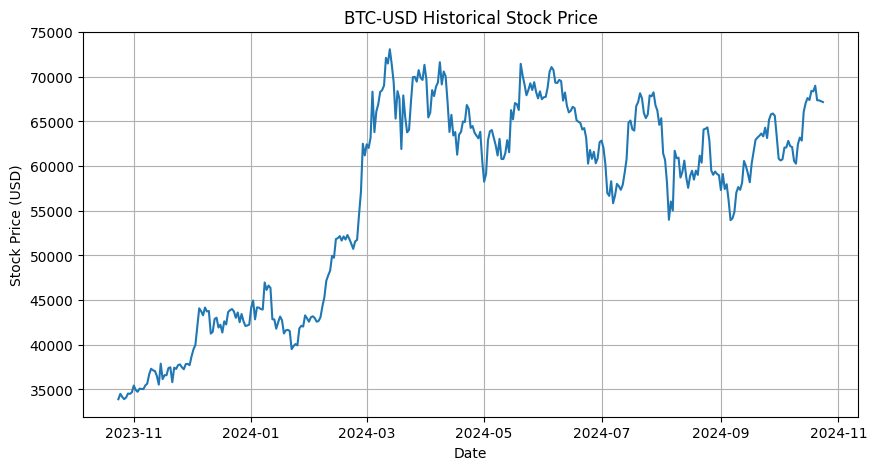

In [114]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score



def fetch_options_data(ticker_symbol, expiration_date):
    ticker = yf.Ticker(ticker_symbol)
    options_dates = ticker.options
    # We'll use the nearest expiry date for our analysis
    options_data = ticker.option_chain(options_dates[expiration_date])
    return options_data.calls, options_data.puts

def fetch_historical_stock_data(ticker_symbol, period="1y"):
    ticker = yf.Ticker(ticker_symbol)
    stock_data = ticker.history(period=period)
    
    if stock_data.empty:
        raise ValueError(f"No historical stock data found for ticker '{ticker_symbol}'.")
    return stock_data

ticker_symbol = "BTC-USD"

#^SPX, SPY, BTC-USD

stock_data = fetch_historical_stock_data(ticker_symbol, period="1y")

plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'])
plt.title(f'{ticker_symbol} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)


In [115]:
# Fetch available expiration dates
ticker = yf.Ticker(ticker_symbol)
expiration_dates = ticker.options

# Print all available expiration dates
print("Available Expiration Dates for SPX:")
for date in expiration_dates:
    print(date)


EXPIRATION_DATE_INDEX = 10 # approx one month
if EXPIRATION_DATE_INDEX < len(expiration_dates):
    expiration_in_one_month = expiration_dates[EXPIRATION_DATE_INDEX]
else:
    print(f"Error: Expiration date index {EXPIRATION_DATE_INDEX} is out of range. Available indices: 0 to {len(expiration_dates) - 1}")
    expiration_in_one_month = -1
    EXPIRATION_DATE_INDEX = -1

# Print the selected expiration date
print(f"\nFetching options for expiration date: {expiration_in_one_month}")

Available Expiration Dates for SPX:
Error: Expiration date index 10 is out of range. Available indices: 0 to -1

Fetching options for expiration date: -1


67169.1875


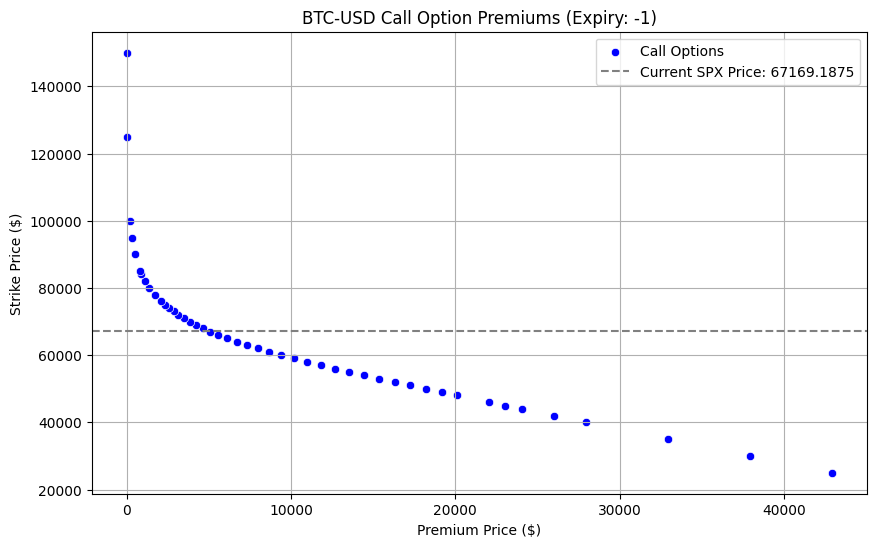

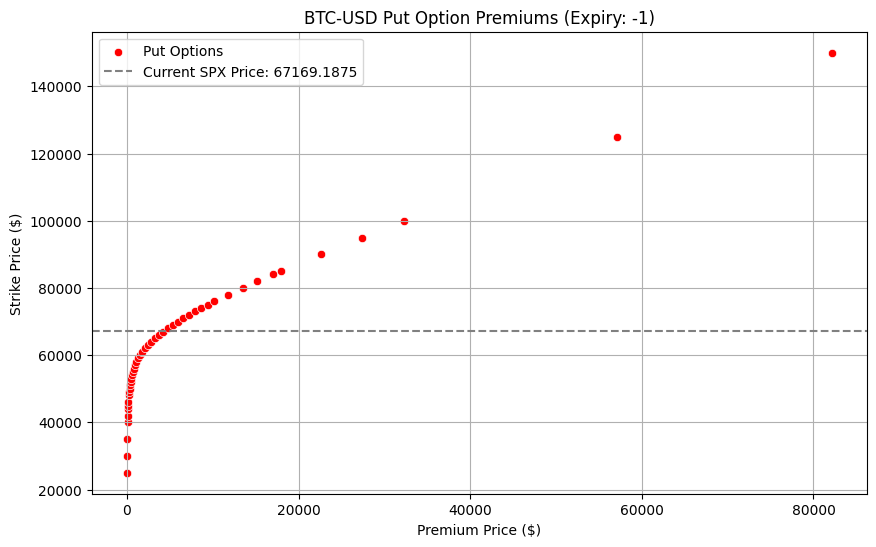

Plotting option premiums for expiration date: -1
Current BTC-USD Price: 67169.1875
Note: The 'lastPrice' represents the most recent trade, which may not always be from today. Check 'volume' for recent trading activity.



In [116]:
def fetch_current_stock_price(ticker_symbol):
    """
    Fetches the current stock price for the given ticker symbol.
    
    Parameters:
    - ticker_symbol (str): The ticker symbol (e.g., 'SPX')
    
    Returns:
    - current_price (float): The latest stock price
    """
    ticker = yf.Ticker(ticker_symbol)
    stock_data = ticker.history(period="1d")
    current_price = stock_data['Close'].iloc[-1]  # Get the most recent closing price
    return current_price

if not ticker_symbol == "BTC-USD":
    spx_calls, spx_puts = fetch_options_data(ticker_symbol, EXPIRATION_DATE_INDEX)

#print(spx_calls)

# Fetch the current stock price
current_stock_price = fetch_current_stock_price(ticker_symbol)
print(current_stock_price)

# Plot Call Option Premiums for SPX with a horizontal line for the current stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spx_calls, x='lastPrice', y='strike', color='blue', label='Call Options')
plt.axhline(y=current_stock_price, color='gray', linestyle='--', label=f'Current SPX Price: {current_stock_price}')
plt.title(f'{ticker_symbol} Call Option Premiums (Expiry: {expiration_in_one_month})')
plt.xlabel('Premium Price ($)')
plt.ylabel('Strike Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Put Option Premiums for SPX with a horizontal line for the current stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spx_puts, x='lastPrice', y='strike', color='red', label='Put Options')
plt.axhline(y=current_stock_price, color='gray', linestyle='--', label=f'Current SPX Price: {current_stock_price}')
plt.title(f'{ticker_symbol} Put Option Premiums (Expiry: {expiration_in_one_month})')
plt.xlabel('Premium Price ($)')
plt.ylabel('Strike Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print the expiration date for clarity
print(f"Plotting option premiums for expiration date: {expiration_in_one_month}")
print(f"Current {ticker_symbol} Price: {current_stock_price}")
print("Note: The 'lastPrice' represents the most recent trade, which may not always be from today. Check 'volume' for recent trading activity.\n")

In [117]:
def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

volatility = calculate_historical_volatility(stock_data)
print(f"{ticker_symbol} Historical Volatility: {volatility}")

# Fetch data for the 13-week T-bill (^IRX is the ticker for the 13-week Treasury Bill index on Yahoo Finance)
t_bill = yf.Ticker("^IRX")
t_bill_data = t_bill.history(period="1d")

# The yield is typically expressed as an annual percentage, so divide by 100
risk_free_rate = t_bill_data['Close'].iloc[-1] / 100
print(f"Estimated risk-free rate (3-month T-Bill): {risk_free_rate}")

BTC-USD Historical Volatility: 0.4249384484756945
Estimated risk-free rate (3-month T-Bill): 0.04505000114440918


In [118]:
class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T        # Time to expiration in years
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))

Number of strike prices call:  47
Number of premium call options:  47
Number of strike prices put:  47
Number of strike prices put:  47
Current stock price: 67169.1875


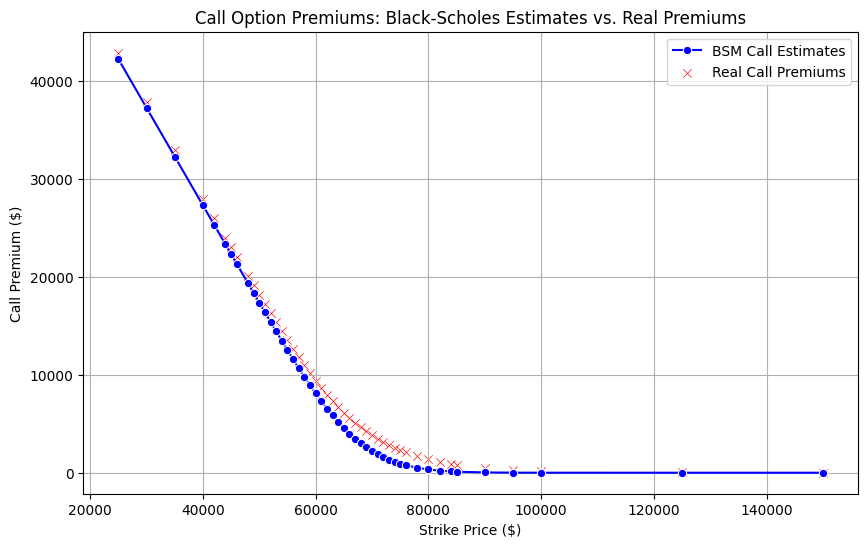

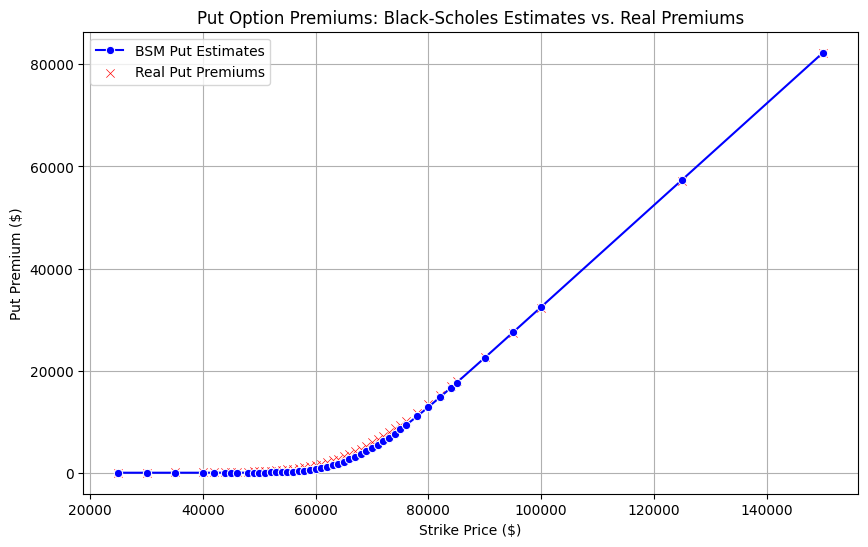

In [119]:
strike_prices_call = spx_calls['strike'].values
strike_prices_put =  spx_puts['strike'].values

real_call_premiums = spx_calls['lastPrice'].values
real_put_premiums = spx_puts['lastPrice'].values

print("Number of strike prices call: ", len(strike_prices_call))
print("Number of premium call options: ", len(real_call_premiums))

print("Number of strike prices put: ",len(strike_prices_put))
print("Number of strike prices put: ",len(real_put_premiums))

bsm_call_premiums = []
bsm_put_premiums = []

print(f"Current stock price: {current_stock_price}")
# Loop through each strike price and calculate the call and put option premiums
for K in strike_prices_call:
    bsm = BlackScholesModel(S=current_stock_price, K=K, T=1/12, r=risk_free_rate, sigma=volatility)
    bsm_call_premiums.append(bsm.call_option_price())

for K in strike_prices_put:
    bsm = BlackScholesModel(S=current_stock_price, K=K, T=1/12, r=risk_free_rate, sigma=volatility)
    bsm_put_premiums.append(bsm.put_option_price())


# Plot Call Option Premiums: Black-Scholes estimates vs. real premiums
plt.figure(figsize=(10, 6))
sns.lineplot(x=strike_prices_call, y=bsm_call_premiums, label='BSM Call Estimates', color='blue', marker='o')
sns.scatterplot(x=strike_prices_call, y=real_call_premiums, label='Real Call Premiums', color='red', marker='x')
plt.title('Call Option Premiums: Black-Scholes Estimates vs. Real Premiums')
plt.xlabel('Strike Price ($)')
plt.ylabel('Call Premium ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Put Option Premiums: Black-Scholes estimates vs. real premiums
plt.figure(figsize=(10, 6))
sns.lineplot(x=strike_prices_put, y=bsm_put_premiums, label='BSM Put Estimates', color='blue', marker='o')
sns.scatterplot(x=strike_prices_put, y=real_put_premiums, label='Real Put Premiums', color='red', marker='x')
plt.title('Put Option Premiums: Black-Scholes Estimates vs. Real Premiums')
plt.xlabel('Strike Price ($)')
plt.ylabel('Put Premium ($)')
plt.legend()
plt.grid(True)
plt.show()



In [120]:
# Call option premiums
r2_call = r2_score(real_call_premiums, bsm_call_premiums)

# Put option premiums
r2_put = r2_score(real_put_premiums, bsm_put_premiums)

# Print R² scores
print(f"R² Score for Call Options: {r2_call:.4f}")
print(f"R² Score for Put Options: {r2_put:.4f}")

R² Score for Call Options: 0.9890
R² Score for Put Options: 0.9980
